In [1]:
! pip install picnik

In [6]:
from picnik import picnik as pnk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
#import seaborn as sns
plt.rcParams.update({'font.size': 14})

### The data used in this examples is a simulated process that follows an F1 reaction model: $f(\alpha)=1-\alpha$, with the Arrhenius parameters: $E=75$ kJ/mol and $\ln{(A/min)} = 12$

### The data represents four thermogravitric experiments of linear temperature programs with heating rates of $(2.5,5,10$ and $20)$ K/min

In [8]:
""" Data """
#The usual definition of the files with experimental data
one_step = ['E_cnt_2.5.csv',
            'E_cnt_5.csv',
            'E_cnt_10.csv',
            'E_cnt_20.csv']

### The extraction of the data is the same in every aspect but one, an additional variable must be defined in the `Isoconversion(` method, which is labeled as `da_DF` in this example (line four of the next cell). This variable is for a method in development so we won't use further, but it is necessary in this step.

Files to be used: 
['E_cnt_2.5.csv', 'E_cnt_5.csv', 'E_cnt_10.csv', 'E_cnt_20.csv']
 
Reading files and creating DataFrames...

The computed heating rates are:

2.50 K/min
5.00 K/min
10.00 K/min
20.00 K/min
The temperature range was set to (400.0,850.0) K
Computing conversion values...
Done


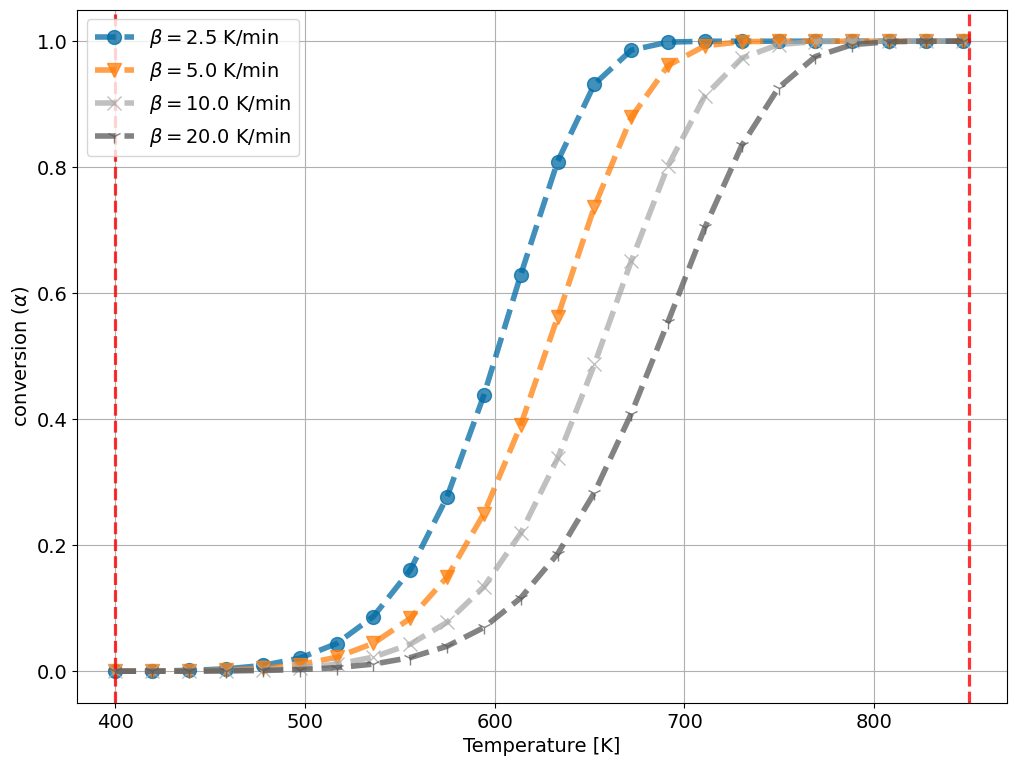

Creating Isoconversion DataFrames...
Done


In [9]:
# The usual DataExtraction commands
xtr = pnk.DataExtraction()
B, T0 = xtr.read_files(one_step)
xtr.Conversion(400,850)
T_DF, t_DF, d_DF, aT_DF, at_DF, da_DF  = xtr.Isoconversion(advanced=True, method='step',d_a = 0.005) #The last element in the left side

In [10]:
# The ActivationEnergy object is summoned as ususal
ace = pnk.ActivationEnergy(B,
                           T0,
                           T_DF,
                           d_DF,
                           aT_DF,
                           at_DF)

## Activation Energy

## The "classic" methods, i.e., Fr(, OFW(, KAS( and Vy( remain the same. While the advanced method of Vyazovkin has suffered some minor modifications. One of them is the possiblity to define the parameter $p$, which defines the level of confidence for the error associated to the activation energy, being 1 a 100%. Other modifications include the integration method (available methods: trapezoid(default),simpson and romberg). The Romberg method may be a little more accurate but takes a lot more of time.  

In [11]:
aVy = ace.aVy((65,80),var='time', p= 0.95, method='trapezoid')

Advanced Vyazovkin method: Computing activation energies...


/usr/local/lib/python3.10/dist-packages/picnik_integrator/picnik_integrator.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  hp = (b-a)/Nprime
/usr/local/lib/python3.10/dist-packages/picnik_integrator/picnik_integrator.py:23: RuntimeWarning: invalid value encountered in double_scalars
  Icp = I0p +(hp*Fcp)


Done.


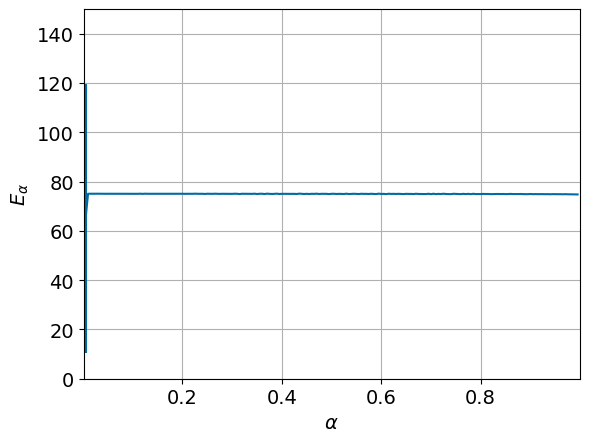

In [12]:
plt.errorbar(aT_DF.index.values[1::],aVy[0],aVy[1])
plt.ylim(0,150)
plt.xlim(0.001,0.999)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_{\alpha}$')
plt.grid(1)

## Pre-exponential factor

## The pre-exponential factor is computed by means of the so-called compensation effect, which implies a linear relation between the pre-exponential factor and the activation energy: $\ln{A}=a+bE$

## A linear regression is computed over a set of {$E_{i}$,$\ln{A_{i}}$} to obtain the parameters $a$ and $b$.
## The values of {$E_{i}$,$\ln{A_{i}}$} are obatined from fitting different models $f(\alpha)_{i}$ (defined in the picnik.rxn_models submodule) to the experimental data

## All this information is returned from the ActivationEnergy.compensation_effect method

In [13]:
ln_A,a, b, Avals, Evals = ace.compensation_effect(aVy[0],B=ace.Beta[0])

Text(0, 0.5, '$ln(A$/min)')

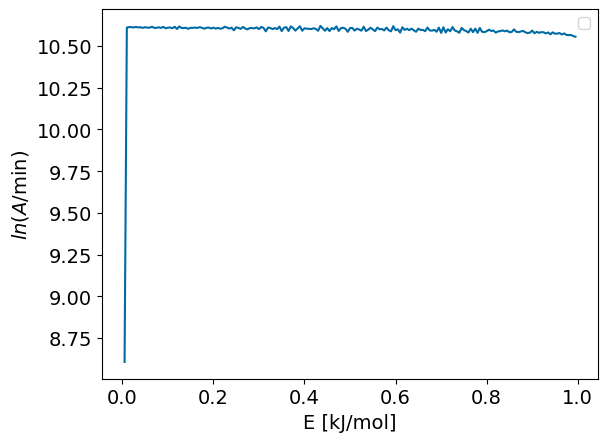

In [14]:
x = Evals
y = (a*x) + b
L = r'$\ln{A} =$ '+str(np.round(a,decimals=3))+'E + '+str(np.round(b,decimals=3))

#plt.plot(aVy[0],ln_A,'-')                              # Uncomment this line to plot ln_A vs E
plt.plot(aT_DF.index.values[1::],ln_A)                 # Uncomment this line to plot ln_A vs alpha
#plt.plot(Evals,np.log(Avals),'g.')                   # Uncomment this line and the one below to plot lnA vs E
#plt.plot(x,y,'teal',label=L,alpha=0.7)
plt.legend(fontsize=11)
plt.xlabel(r'E [kJ/mol]')
plt.ylabel(r'$ln(A$/min)')
#plt.xlim(0,170)
#plt.ylim(0,35)

## Model reconstruction

## The numerical reconstruction of the reaction model is carried on in its integral form, $g(\alpha)$
## Given an array of activation energy, $E$, and an array of pre-exponential factor, the integral reaction model can be computed as:
## $g(\alpha) = \sum_{i} g(\alpha_{i}) = \sum_{i} A_{\alpha_{i}} \int_{t_{\alpha_{i-1}}}^{t_{\alpha_{i}}}\exp(-\frac{E_{\alpha_{i}}}{RT(t_{\alpha_{i}})})dt$

In [15]:
g_r  = ace.reconstruction(aVy[0],np.exp(ln_A), 3,N=1)
g_r2 = ace.reconstruction(aVy[0],np.exp(12)*np.ones(len(aVy[0])), 3,N=1)
g_r3 = ace.reconstruction(np.mean(aVy[0])*np.ones(len(aVy[0])),np.exp(12)*np.ones(len(aVy[0])), 3,N=1)

### The cell below plots different reaction models in the integral form, $g(\alpha)_{i}$. As we are using F1 generated data, our reconstructed data should be overlapping with the values of the F1 model.

### As noted by inspection of the plot of $\ln{A}$ vs $\alpha$, the value of $\ln{A}$ (~ 10.6) differs from the progammed one (12), giving thus an unreliable reconstruction, which is why g_r doesn reproduced the simulated data. If one uses the programmed value for $\ln{A}$ and the computed values with the `aVy(` method (g_r2) there is still a discrepancy between the computed data and the real model. Finally, by using the average of the activation energy array (g_r3) we recover the simulated model. The moral is, the `compensation_effect(` (as programmed in picnik) is unreliable and if you wish to recompute numerically $g(\alpha)$, you need to be sure that the process is single step and use the averge activation energy.

In [17]:
import seaborn as sns

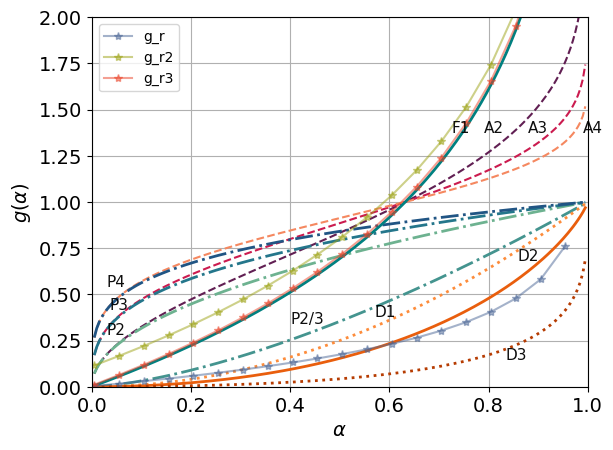

In [18]:
color_A = sns.color_palette("rocket",3)
color_P = sns.color_palette("crest",4)
color_D = sns.color_palette("Oranges",5)
alpha = aT_DF.index.values[1::]
plt.plot(alpha,pnk.rxn_models.A2(alpha,integral=True),ls='--',color=color_A[0])#,label='A2',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.A3(alpha,integral=True),ls='--',color=color_A[1])#,label='A3',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.A4(alpha,integral=True),ls='--',color=color_A[2])#,label='A4',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.P2(alpha,integral=True),ls='-.',color=color_P[0],lw=2)#,label='P2',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.P2_3(alpha,integral=True),ls='-.',color=color_P[1],lw=2)#,label='P2/3',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.P3(alpha,integral=True),ls='-.',color=color_P[2],lw=2)#,label='P3',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.P4(alpha,integral=True),ls='-.',color=color_P[3],lw=2)#,label='P4',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.D1(alpha,integral=True),ls=':',color=color_D[2],lw=2)#,label='D1',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.D2(alpha,integral=True),ls='-',color=color_D[3],lw=2)#,label='D2',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.D3(alpha,integral=True),ls=':',color=color_D[4],lw=2)#,label='D3',alpha=0.7)
plt.plot(alpha,pnk.rxn_models.F1(alpha,integral=True),color='teal',lw=2)#,label='F1',alpha=0.7)

plt.text(0.725,1.375,'F1',fontsize=11,alpha=0.95)
plt.text(0.790,1.375,'A2',fontsize=11,alpha=0.95)
plt.text(0.880,1.375,'A3',fontsize=11,alpha=0.95)
plt.text(0.990,1.375,'A4',fontsize=11,alpha=0.95)
plt.text(0.400,0.340,'P2/3',fontsize=11,alpha=0.95)
plt.text(0.030,0.280,'P2',fontsize=11,alpha=0.95)
plt.text(0.035,0.415,'P3',fontsize=11,alpha=0.95)
plt.text(0.030,0.540,'P4',fontsize=11,alpha=0.95)
plt.text(0.570,0.380,'D1',fontsize=11,alpha=0.95)
plt.text(0.858,0.682,'D2',fontsize=11,alpha=0.95)
plt.text(0.834,0.145,'D3',fontsize=11,alpha=0.95)


plt.plot(alpha[:-1:][::10],g_r[::10],'*-',color='#4B6696',label='g_r',alpha=0.5)
plt.plot(alpha[:-1:][::10],g_r2[::10],'*-',color='#9DA315',label='g_r2',alpha=0.5)
plt.plot(alpha[:-1:][::10],g_r3[::10],'*-',color='#EB4328',label='g_r3',alpha=0.5)

plt.ylim(0,2)
plt.xlim(0,1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$g(\alpha)$')
plt.grid(1)
plt.legend(fontsize=10)

### Isothermal prediction

### For this example, the conversion as a function of time is given by: $\alpha(t) = 1-\exp{[-A\exp(-\frac{E}{RT})t]} $
### We compare the results of the computed predictions with three picnik methods, each based on a different equation:

### a) Model based prediction:          $t_{\alpha_{i}} = \frac{\sum_{i}g(\alpha_{i})}{A\exp{(-\frac{E}{RT_{0}})}}$   ...(1)
### b) Isoconversion prediction A:      $t_{\alpha_{i}} = \frac{\int_{t_{\alpha_{0}}}^{t_{\alpha_{i}}}\exp(-\frac{E}{RT(t)})}{\exp{(-\frac{E}{RT_{0}})}}$   ...(2)
### c) Isoconversion prediction B:      $J[E_{\alpha},T(t)]=J[E_{\alpha},T_{0}]$   ...(3)

### As it can be seen from the expressions above, the methods do not compute conversion as a funciton of time, but they compute the time required to reach a given conversion

### The next three cells have the following contents:
### The first one, defines conversion as a function of time according to the F1 model and creates tima and conversion arrays ti plot.
### The second one has the three tipes of prediction according to the equations above
### The third one is a plot of the predictions and the model

### It is clear that all three equations give accurate isothermal predictions. Althoug we recommend the one of equation (3) as it implies less assumptions about the process

In [22]:
def alpha_F1_iso(t,A,E,isoT):
    return 1- np.exp(-A*np.exp(-E/(0.0083144626*isoT))*t)

time = np.linspace(0,200,len(aVy[0]))                                    # Time arrays to comupute the theoretical conversion values
alp  = alpha_F1_iso(time,np.exp(12),75,575)                               # Theoretical conversion with E = 75 kJ/mol and ln(A/min)=12

In [23]:
tim_pred1 = ace.t_isothermal(aVy[0],np.exp(ln_A),575,col=0,g_a=g_r,alpha=alpha)       # Prediction with eq (1)
tim_pred2 = ace.t_isothermal(aVy[0],np.exp(ln_A),575,col=0,isoconv=True)              # Prediction with eq (2)
ap,Tp,tp  = ace.prediction(aVy[0],B=0,isoT =575, alpha=0.999,N=1,bounds = (10,10))  # Prediction with eq (3)

/usr/local/lib/python3.10/dist-packages/picnik_integrator/picnik_integrator.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  hp = (b-a)/Nprime
/usr/local/lib/python3.10/dist-packages/picnik_integrator/picnik_integrator.py:23: RuntimeWarning: invalid value encountered in double_scalars
  Icp = I0p +(hp*Fcp)


Beginning simulation at :  0  min


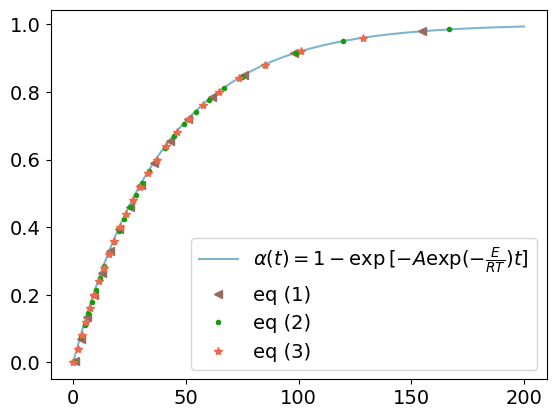

In [24]:
plt.plot(time,alp,alpha=0.5,label=r'$\alpha(t) = 1-\exp{[-A\exp(-\frac{E}{RT})t]}$')
plt.plot(tim_pred1[::13],at_DF.index.values[1:][::13],'<',c='#966B60',label='eq (1)')
plt.plot(tim_pred2[::7],at_DF.index.values[1:-1:7],'.',c='#169C09',label='eq (2)')
plt.plot(tp[::8],ap[::8],'*',c='#EB6A49',label='eq (3)')

plt.legend()

## Non-isothermal predictioin

## In this section we ilustrate the use of the methods for non-isothermal predictions with linear, or an arbitrary temperature program

In [25]:
# This is a prediction of the conversion under a linear heating rate of 10 K/min
ap2,Tp2,tp2 = ace.prediction(aVy[0],B=10,alpha=0.999, N=1,bounds = (10,10))

Beginning simulation at :  0  min


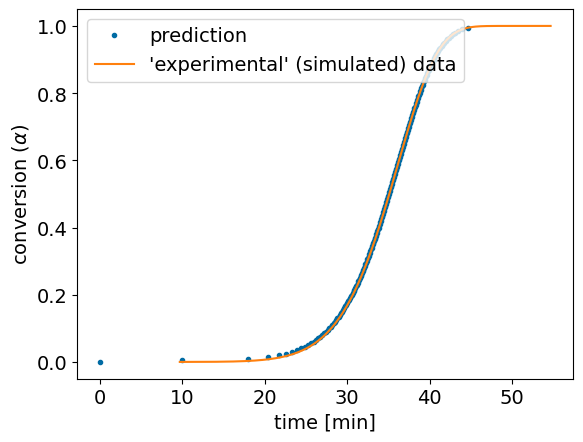

In [26]:
plt.plot(tp2,ap2,'.',label='prediction')
plt.plot(xtr.t[2],xtr.alpha[2],label="'experimental' (simulated) data")

plt.ylabel(r'conversion ($\alpha$)')
plt.xlabel('time [min]')
plt.legend(loc='upper left')

In [27]:
def Temp_program(t):
    """"
    Temperaure program with isothermal and linear steps: a linear ramp with heating rate of 5 K/min for
    53 minutes (to reach a temperature of 575 K), then, isothermal until process reaches a 100% conversion
    """
    if t <= 53:
        return 35+273 + 5*t
    else:
        return 575

In [28]:
# This is a prediction of the conversion under a mixed temperaure program with isothermal and linear steps
ap3,Tp3,tp3 = ace.prediction(aVy[0],B=10,T_func = Temp_program,alpha=0.999, N=1,bounds = (10,10))

Beginning simulation at :  0  min


Text(0.5, 0, 'time [min]')

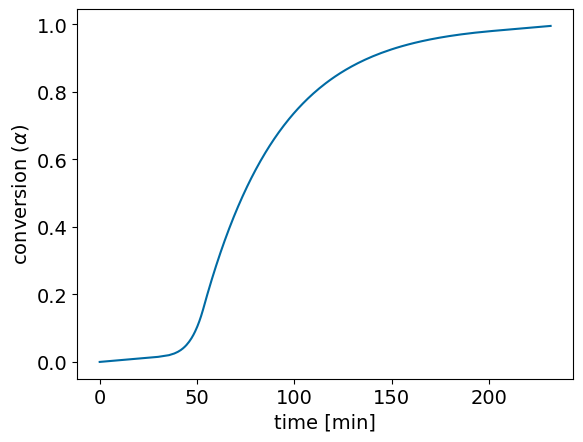

In [29]:
plt.plot(tp3,ap3)
plt.ylabel(r'conversion ($\alpha$)')
plt.xlabel('time [min]')

### Exporting results

In [33]:
len(g_r)

198

In [34]:
#Activation energy
ace.export_Ea(E_aVy=True,file_t='csv')
#kinetic triplet
ace.export_kinetic_triplet(E=aVy[0][1::],ln_A=ln_A[1::], g_a=g_r)
#prediction
ace.export_prediction(time=tp,Temp=Tp,alpha=ap)

Exporting activation energies...
Input file name for the adv.Vy results:Ea_aVy
Results exported
Done.


In [31]:
help(ace.export_prediction)

Help on method export_prediction in module picnik.picnik:

export_prediction(time, Temp, alpha, name='prediction.csv') method of picnik.picnik.ActivationEnergy instance
    Method to export the kinetic prediction.
    
    Parameters:     time    : Time array.
    
                    Temp    : Temperature array.
    
                    alpha   : Conversion array.
    
                    name    : File name in .csv format.
    
    Returns:    None. A file will be created according to the working path or path specified in `name`.



In [ ]:
# For more information on the prediction method run this cell
help(ace.prediction)